In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

from scipy.optimize import minimize
from math import sin

FPS = 24

In [2]:
plt.rcParams["figure.figsize"] = (20,10)

In [3]:
# arm radius
r_m = 0.5 # m
m_kg = 4
# arm inertia
theta = m_kg * r_m ** 2
Fg = m_kg * 9.81
# damper
k = 0.1

## disturbances / plant model
r_real_m = r_m + 0.1 # m
k_real = k + 0.1
angle_noise_std = np.deg2rad(2) # rad
angle_vel_noise_std = np.deg2rad(6) # rad/s
motor_noise_std = 2 # N

def system_dynamics(x, u):  
    x1, x2 = x
    
    dx_dt = [
        x2,
        r_m / theta * (Fg * sin(x1) - u) - k * x2
    ]
    
    return np.array(dx_dt)

def system_dynamics_plant(x, u):  
    x1, x2 = x
    
    # IMU noise
    x1 += np.random.normal(0, angle_noise_std)
    x2 += np.random.normal(0, angle_vel_noise_std)
    # Motor noise
    u += np.random.normal(0, motor_noise_std)
    
    dx_dt = [
        x2,
        (r_real_m) / theta * (Fg * sin(x1) - u) - (k_real) * x2
    ]
    
    return np.array(dx_dt)

assert np.allclose(system_dynamics([np.deg2rad(90), 0], Fg), [0,0])

In [4]:
x0 = np.array([np.deg2rad(90), 0])

duration_s = 180

# this cant be too small for it to work
delT = 0.01
N = 4
n_steps = int(duration_s / delT)

opti_options = {"maxfun":3}

In [5]:
x = x0
xs = [x]
us = [0]

u_traj_init = np.ones(N)
u = None

for i in range(n_steps):
    if u is not None:
        # warm start using state similarity
        # initial value embedding
        u_traj_init = u_opt
    
    Q = [
        [4,0],
        [0,1]
    ]
    
    # this has to be very small because we weight N vs radians
    # i.e. if x and u are weighted the same, a relatively small
    # deviation in u of 1N is weighted the same as ~60°
    R = 0.00001
    
    def obj(u_traj):
        xk = x
        
        # single-shooting
        cost = 0
        for k in range(N):
            uk = u_traj[k]
            
            cost += 1/2 * (xk.T @ Q @ xk + uk * R * uk)
            
            xk1 = xk + delT * system_dynamics(xk, uk)
            xk = xk1
        
        return cost
    
    def jac(u_traj):
        return R * u_traj

    res = minimize(obj, u_traj_init, options=opti_options, method="L-BFGS-B")
    
    if not res.success and not "EVALUATIONS EXCEEDS LIMIT" in str(res.message):
        print("optimization failed ", i)
        print(res)
        break
    
    # use first control input
    u_opt = res.x
    u = u_opt[0]
    
    x = x + delT * system_dynamics_plant(x, u)
    
    if i % 100 == 0:
        print(f"In step {i}/{n_steps} u={u:.2f}N, x={x.T}")
    
    us.append(u)
    xs.append(x)

xs = np.array(xs)
us = np.array(us)

In step 0/18000 u=16.80N, x=[1.57106449 0.15490884]
In step 100/18000 u=36.98N, x=[ 1.48071788 -0.08421106]
In step 200/18000 u=38.38N, x=[ 1.39019768 -0.10521822]
In step 300/18000 u=42.23N, x=[ 1.31899931 -0.07840471]
In step 400/18000 u=37.48N, x=[ 1.21684032 -0.08331672]
In step 500/18000 u=34.95N, x=[ 1.12280479 -0.10163651]
In step 600/18000 u=34.51N, x=[ 1.04116845 -0.06864734]
In step 700/18000 u=34.91N, x=[ 0.99348177 -0.00599895]
In step 800/18000 u=29.78N, x=[ 0.92129275 -0.09658911]
In step 900/18000 u=30.90N, x=[ 0.85912079 -0.05643222]
In step 1000/18000 u=29.25N, x=[ 0.81326835 -0.07473609]
In step 1100/18000 u=28.47N, x=[ 0.76336854 -0.07201823]
In step 1200/18000 u=24.36N, x=[ 0.70692229 -0.06438248]
In step 1300/18000 u=23.25N, x=[ 0.66085207 -0.04932149]
In step 1400/18000 u=22.30N, x=[ 0.63227185 -0.04819868]
In step 1500/18000 u=21.02N, x=[ 0.59314378 -0.02946851]
In step 1600/18000 u=20.71N, x=[ 0.5519322  -0.02654502]
In step 1700/18000 u=19.30N, x=[ 0.53119376 -

''

SyntaxError: 'return' outside function (<ipython-input-6-9a0bf6afa00f>, line 38)

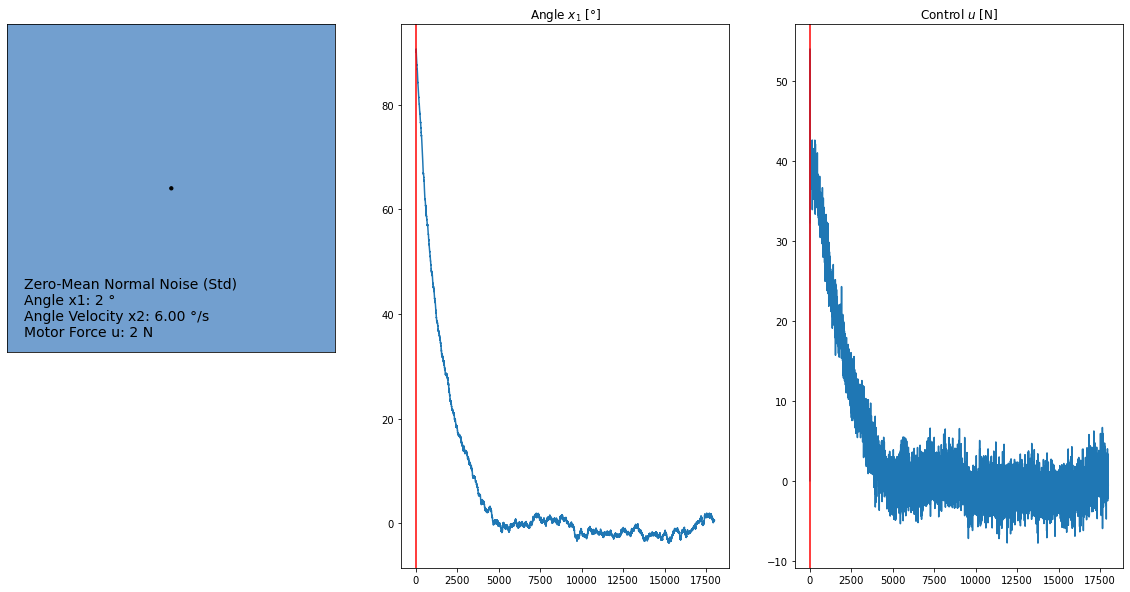

In [6]:
hdisplay = display.display("", display_id=True)

fig, axes = plt.subplots(ncols=3)

axes[0].set_xlim((-2,2))
axes[0].set_ylim((-2,2))
axes[0].set_aspect("equal")

###
axes[0].set_facecolor("#729fcf")
axes[0].tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)
axes[0].set_anchor("N")
plt.figtext(0.05,0,f"""
Zero-Mean Normal Noise (Std)
Angle x1: {np.rad2deg(angle_noise_std):.0f} °
Angle Velocity x2: {np.rad2deg(angle_vel_noise_std):.2f} °/s
Motor Force u: {motor_noise_std:.0f} N
""", fontsize=14, transform=axes[0].transAxes)
###

axes[1].plot(np.rad2deg(xs[:,0]))
axes[1].set_title("Angle $x_1$ [°]")
oi = axes[1].axvline(0, color="r")

axes[2].plot(us)
axes[2].set_title("Control $u$ [N]")
oi2 = axes[2].axvline(0, color="r")

# center bearing
axes[0].add_artist(plt.Circle([0,0], radius=0.02, color="k"))

line_arm = axes[0].plot([],[], "k")
line_force = axes[0].plot([],[], "r")

return

step = round(n_steps/50)
print("Step", step)
time_last = 0
for kk, state in enumerate(xs[::step]):
    phi, dphi = state
    k = kk*step
    
    #todo
    r = 0.5
    F = us[k]
    
    x = r * np.sin(phi)
    y = r * np.cos(phi)
    
    x_force = x + F * np.cos(phi)
    y_force = y - F * np.sin(phi)
    
    line_arm[0].set_data([0,x],[0,y])
    line_force[0].set_data([x, x_force],[y, y_force])
    oi.set_xdata(k)
    oi2.set_xdata(k)
    
    hdisplay.update(fig)
    if time.time() - time_last < 1/FPS:
        time.sleep(1/FPS - (time.time() - time_last))
        
    time_last = time.time()
plt.close(fig)

## Video Rendering

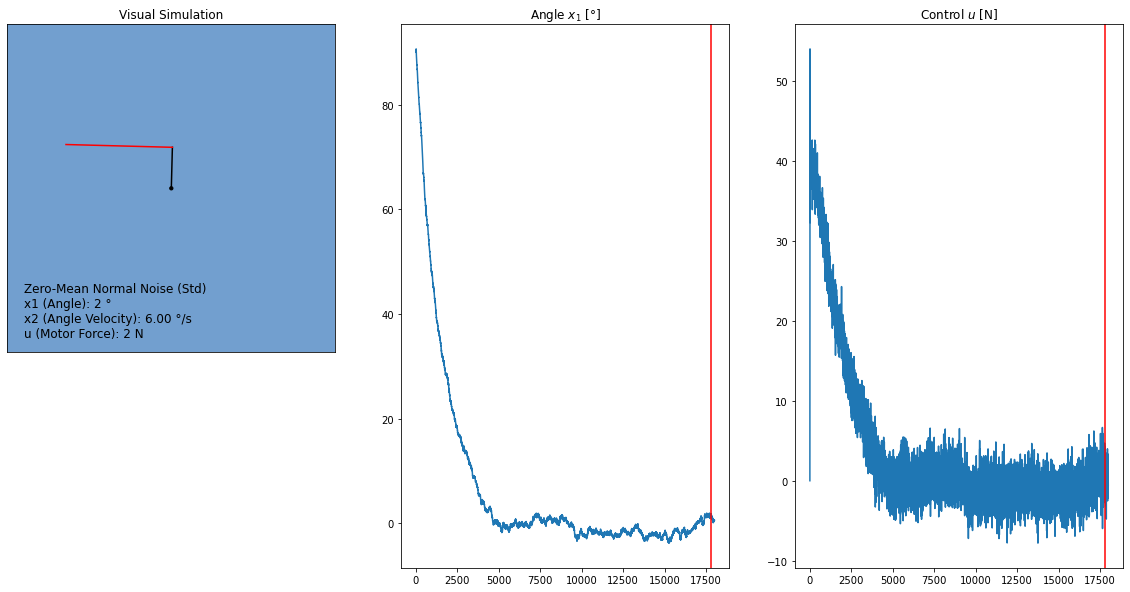

In [7]:
from matplotlib import animation, rc
from IPython.display import HTML

fig, axes = plt.subplots(ncols=3)

axes[0].set_xlim((-2,2))
axes[0].set_ylim((-2,2))
axes[0].set_aspect("equal")
axes[0].set_facecolor("#729fcf")
axes[0].tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)
axes[0].set_title("Visual Simulation")
axes[0].set_anchor("N")
plt.figtext(0.05,0,f"""
Zero-Mean Normal Noise (Std)
x1 (Angle): {np.rad2deg(angle_noise_std):.0f} °
x2 (Angle Velocity): {np.rad2deg(angle_vel_noise_std):.2f} °/s
u (Motor Force): {motor_noise_std:.0f} N
""", fontsize=12, transform=axes[0].transAxes)

axes[1].plot(np.rad2deg(xs[:,0]))
axes[1].set_title("Angle $x_1$ [°]")
oi = axes[1].axvline(0, color="r")

axes[2].plot(us)
axes[2].set_title("Control $u$ [N]")
oi2 = axes[2].axvline(0, color="r")

# center bearing
axes[0].add_artist(plt.Circle([0,0], radius=0.02, color="k"))

line_arm = axes[0].plot([],[], "k")
line_force = axes[0].plot([],[], "r")

def animate(k):
    state = xs[k]
    phi, dphi = state

    r = 0.5
    F = us[k]

    x = r * np.sin(phi)
    y = r * np.cos(phi)

    x_force = x + F * np.cos(phi)
    y_force = y - F * np.sin(phi)

    line_arm[0].set_data([0,x],[0,y])
    line_force[0].set_data([x, x_force],[y, y_force])
    oi.set_xdata(k)
    oi2.set_xdata(k)
    
    return (oi, oi2)

step = round(n_steps/100)
anim = animation.FuncAnimation(fig, animate, frames=np.arange(len(xs)//step) * step, interval=1000//30, blit=True)
HTML(anim.to_html5_video())

In [8]:
anim.save('ventilator-mpc.mp4', codec='h264')